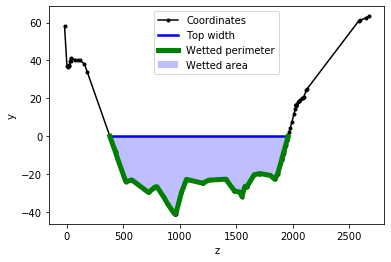

In [1]:
%matplotlib inline

import numpy as np

from pantherapy.panthera import CrossSection


roughness = 0.035
z, y = np.loadtxt('data/stlms/xs.csv', delimiter=',', skiprows=1, unpack=True)
datum = 379.58
y = y - datum
sect = CrossSection(y, z, roughness)

_ = sect.plot(0)

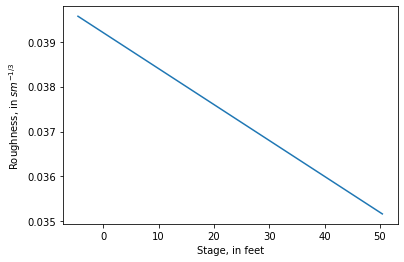

In [2]:
import matplotlib.pyplot as plt

from dynrat.frict import TableFrict


stage = np.array([-4.58, 50.42])
roughness = (-0.00008*stage)+0.0392

frict = TableFrict(stage, roughness)

_ = plt.plot(stage, roughness)
_ = plt.xlabel('Stage, in feet')
_ = plt.ylabel(r'Roughness, in ${s}{m^{-1/3}}$')

In [3]:
from dynrat.rslope import r_slope


h_o = 4.68  # stage prior to start of typical flood
h_p = 24.18  # peak stage of typical flood
q_o = 129000  # flow prior to typical flood
q_p = 396000  # peak flow of typical flood
t_diff = 7.58  # elapsed time of stage rise to peak stage in days

bed_slope = 0.00011

slope_ratio = r_slope(h_o, h_p, q_o, q_p, bed_slope, sect, t_diff)
slope_ratio

20.57622007239142

In [4]:
from dynrat.dynmod import QSolve


time_step = 60*60

q_solve = QSolve(sect, frict, bed_slope, slope_ratio, time_step)

In [5]:
import pandas as pd

qh_data = pd.read_csv('data/stlms/qh.csv', index_col=0, parse_dates=True)
qh_data.head()

,h,Q_rated,Q_computed
datetime,,,
2015-06-01 00:00:00,26.79,439000,NaN
2015-06-01 01:00:00,26.78,439000,436188.1949
2015-06-01 02:00:00,26.75,438000,433609.1328
2015-06-01 03:00:00,26.78,439000,438134.6427
2015-06-01 04:00:00,26.76,439000,434464.5024


In [6]:
from dynrat.timeseries import QTimeSeries


h0 = qh_data.values[0, 0]
q0 = qh_data.values[0, 1]
h_ts = qh_data.values[1:, 0]

qts = QTimeSeries(q_solve)
q = qts.solve_ts(h_ts, q0, h0)

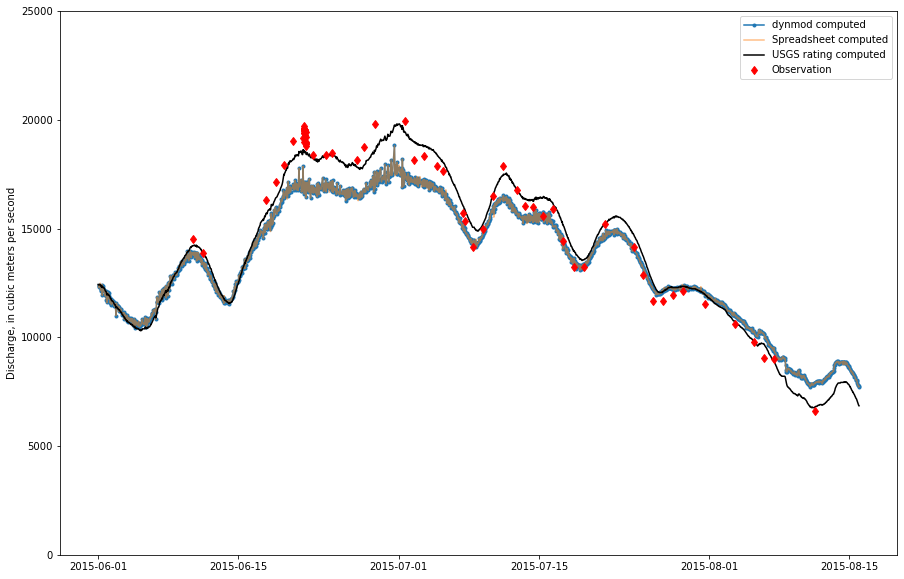

In [7]:
FEET_TO_METERS = (2.54*12)/100
CFS_TO_CMS = FEET_TO_METERS**3

q_obs = pd.read_csv('data/stlms/qobs.csv', index_col=0, parse_dates=True)

_ = plt.figure(figsize=(15,10))
_ = plt.plot(qh_data.index[1:], CFS_TO_CMS*q, marker='.', label='dynmod computed')
_ = plt.plot(qh_data.index[1:], CFS_TO_CMS*qh_data.iloc[1:, 2], label='Spreadsheet computed', alpha=0.5)
_ = plt.plot(qh_data.index, CFS_TO_CMS*qh_data['Q_rated'], label='USGS rating computed', color='k')
_ = plt.plot(q_obs.index, CFS_TO_CMS*q_obs['Q_obs'], label='Observation', linestyle='None', marker='d', color='r')
_ = plt.ylabel('Discharge, in cubic meters per second')
_ = plt.legend()

_ = plt.ylim((0, 25000))

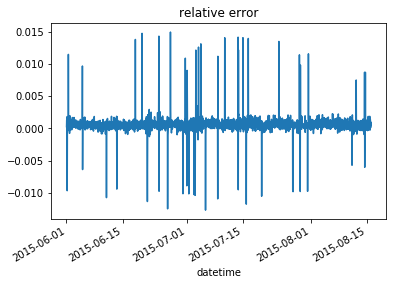

In [8]:
_ = ((q - qh_data.iloc[1:, 2])/qh_data.iloc[1:, 2]).plot()
_ = plt.title('relative error')

In [9]:
np.abs((q - qh_data.iloc[1:, 2])/qh_data.iloc[1:, 2]).max()

0.015009842894604301